In [2]:
# Full pipeline (clean → compute Ey → SurvivalScore → models)
import pandas as pd, numpy as np, re, joblib
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, accuracy_score, classification_report

file_path = "MergedExcel.xlsx"   # adjust path if needed
out_dir = Path("astroMat_outputs")
out_dir.mkdir(exist_ok=True)

xls = pd.ExcelFile(file_path)
sheet_names = xls.sheet_names

def find_col(cols, patterns):
    cols_l = [str(c).lower() for c in cols]
    for pat in patterns:
        for i,c in enumerate(cols_l):
            if pat in c:
                return cols[i]
    return None

rows = []
for sname in sheet_names:
    try:
        df = pd.read_excel(xls, sheet_name=sname)
    except:
        continue
    cols = df.columns.tolist()
    mat_col = find_col(cols, ["material","sample id","sample","trade name","material name"])
    density_col = find_col(cols, ["density","dens"])
    ash_col = find_col(cols, ["ash","mass fraction of ash","mass fraction"])
    ey_col = find_col(cols, ["ey","erosion yield","erosion_yield"])
    massloss_col = find_col(cols, ["mass loss","massloss","mass_loss"])
    area_col = find_col(cols, ["surface area","surface_area"])
    fluence_col = find_col(cols, ["fluence","ao fluence","ram fluence"])
    solar_col = find_col(cols, ["solar","esh","solar exposure"])
    thickness_col = find_col(cols, ["thickness","thickness (mils)"])
    orientation_col = find_col(cols, ["orientation","tray","ram","zenith","wake"])
    if mat_col is None:
        possible = cols[0] if cols else None
        if possible and df[possible].dtype == object:
            mat_col = possible
    if mat_col is None:
        continue
    for idx, r in df.iterrows():
        mat = r.get(mat_col)
        if pd.isna(mat):
            continue
        entry = {"Sheet": sname, "Material_raw": str(mat).strip()}
        def getnum(col):
            if col is None: return np.nan
            v = r.get(col)
            if pd.isna(v): return np.nan
            try: return float(v)
            except:
                s = str(v)
                m = re.search(r"[-+]?[0-9]*\.?[0-9]+([eE][-+]?\d+)?", s)
                if m:
                    try: return float(m.group(0))
                    except: return np.nan
                return np.nan
        entry["Density"] = getnum(density_col)
        entry["AshFraction"] = getnum(ash_col)
        entry["Ey_reported"] = getnum(ey_col)
        entry["MassLoss_g"] = getnum(massloss_col)
        entry["SurfaceArea_cm2"] = getnum(area_col)
        entry["AO_Fluence"] = getnum(fluence_col)
        entry["Solar_ESH"] = getnum(solar_col)
        entry["Thickness_mils"] = getnum(thickness_col)
        entry["Orientation"] = r.get(orientation_col) if orientation_col else np.nan
        rows.append(entry)

master = pd.DataFrame(rows)

def compute_ey(row):
    if pd.notna(row["Ey_reported"]): return row["Ey_reported"]
    if pd.notna(row["MassLoss_g"]) and pd.notna(row["SurfaceArea_cm2"]) and pd.notna(row["AO_Fluence"]) and pd.notna(row["Density"]) and row["Density"]>0:
        vol = row["MassLoss_g"] / row["Density"]
        ey = vol / (row["SurfaceArea_cm2"] * row["AO_Fluence"])
        return ey
    return np.nan

master["Ey_computed"] = master.apply(compute_ey, axis=1)
master["Ey"] = master["Ey_reported"].fillna(master["Ey_computed"])

def normalize_name(s):
    if pd.isna(s): return ""
    s = str(s).strip().lower()
    s = re.sub(r'[\s\(\)\[\]\*]+', ' ', s)
    s = re.sub(r'\s+', ' ', s).strip()
    return s

master["Material_key"] = master["Material_raw"].apply(normalize_name)

# default densities mapping (common materials)
known_density = {
    "kapton h pi":1.4273, "kapton hn pi":1.4345, "fep":2.1443, "al fep":2.1443, "ptfe":2.1503,
    "pvf white tedlar":1.6241, "pvf clear tedlar":1.3792, "abs":1.05, "pc":1.1231, "pbt":1.3318,
    "pmma":1.1628, "pan":1.1435, "pom delrin":1.3984, "pvdf kynar":1.7623, "pg pyrolytic graphite":2.22
}
master["Density"] = master.apply(lambda r: known_density.get(r["Material_key"], r["Density"]), axis=1)

master = master[master["Ey"].notna() & master["Density"].notna()].copy()
master = master[np.isfinite(master["Ey"]) & (master["Ey"]>0)].copy()

agg = master.groupby("Material_key").agg(
    Material_raw = ("Material_raw", lambda x: x.mode().iat[0] if len(x)>0 else x.iloc[0]),
    Ey_mean = ("Ey", "mean"),
    Ey_count = ("Ey", "count"),
    Density = ("Density", "median"),
    AshFraction = ("AshFraction", "median"),
    AO_Fluence = ("AO_Fluence", "median"),
    SurfaceArea_cm2 = ("SurfaceArea_cm2","median"),
    Thickness_mils = ("Thickness_mils","median"),
    Solar_ESH = ("Solar_ESH","median")
).reset_index()

# drop columns that have no data
for c in ["AshFraction","AO_Fluence","SurfaceArea_cm2","Thickness_mils","Solar_ESH"]:
    if c in agg.columns and agg[c].isna().all():
        agg.drop(columns=[c], inplace=True)

for c in agg.columns:
    if agg[c].dtype.kind in 'fiu' and agg[c].isna().any():
        agg[c] = agg[c].fillna(agg[c].median())

agg["log10_Ey"] = np.log10(agg["Ey_mean"])
min_log = agg["log10_Ey"].min(); max_log = agg["log10_Ey"].max()
agg["SurvivalScore"] = 100 * (1 - (agg["log10_Ey"] - min_log) / (max_log - min_log))
agg["SurvivalScore"] = agg["SurvivalScore"].round(2)
def survival_class(score):
    if score >= 75: return "High"
    if score >= 40: return "Medium"
    return "Low"
agg["SurvivalClass"] = agg["SurvivalScore"].apply(survival_class)

agg.to_csv(out_dir / "cleaned_materials_master.csv", index=False)
agg.to_excel(out_dir / "cleaned_materials_master.xlsx", index=False)

numeric_cols = [c for c in ["Density","AshFraction","AO_Fluence","Thickness_mils","Solar_ESH"] if c in agg.columns]
X = agg[numeric_cols].copy()
y_reg = agg["log10_Ey"].copy()
y_clf = agg["SurvivalClass"].copy()

num_imputer = SimpleImputer(strategy="median")
X_imputed = pd.DataFrame(num_imputer.fit_transform(X), columns=X.columns, index=X.index)
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_imputed), columns=X.columns, index=X.index)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_reg, test_size=0.2, random_state=42)
rf_reg = RandomForestRegressor(n_estimators=500, random_state=42)
rf_reg.fit(X_train, y_train)
y_pred = rf_reg.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

Xc_train, Xc_test, yc_train, yc_test = train_test_split(X_scaled, y_clf, test_size=0.2, random_state=42)
rf_clf = RandomForestClassifier(n_estimators=300, random_state=42)
rf_clf.fit(Xc_train, yc_train)
yc_pred = rf_clf.predict(Xc_test)
acc = accuracy_score(yc_test, yc_pred)

joblib.dump(rf_reg, out_dir / "rf_reg_log10ey.joblib")
joblib.dump(rf_clf, out_dir / "rf_clf_survivalclass.joblib")
joblib.dump(num_imputer, out_dir / "num_imputer.joblib")
joblib.dump(scaler, out_dir / "scaler.joblib")

test_idx = X_test.index
preds = pd.DataFrame({
    "Material_key": agg.loc[test_idx, "Material_key"],
    "Material_raw": agg.loc[test_idx, "Material_raw"],
    "Ey_mean": agg.loc[test_idx, "Ey_mean"],
    "log10_Ey_actual": y_test,
    "log10_Ey_pred": y_pred
}).reset_index(drop=True)
preds["Ey_pred_cm3_per_atom"] = 10 ** preds["log10_Ey_pred"]
preds["SurvivalScore_pred"] = 100 * (1 - (preds["log10_Ey_pred"] - min_log) / (max_log - min_log))
preds["SurvivalClass_pred"] = preds["SurvivalScore_pred"].apply(lambda s: "High" if s>=75 else ("Medium" if s>=40 else "Low"))

preds.to_csv(out_dir / "predictions_testset.csv", index=False)
agg.to_csv(out_dir / "agg_full_dataset.csv", index=False)

print("Done. Files in:", out_dir)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Done. Files in: astroMat_outputs


In [3]:
# Robust predictor + file-finder script for AstroMat
# Copy/paste into your notebook cell and run.

import os, sys, joblib, pandas as pd, numpy as np

def find_file(filename, start_paths=None):
    """Search common locations and walk directories to find filename."""
    if start_paths is None:
        start_paths = [
            ".", "./astroMat_outputs", "./outputs", os.path.expanduser("~"),
            "/mnt/data", "/mnt/data/astroMat_outputs"
        ]
    for sp in start_paths:
        if not os.path.exists(sp):
            continue
        for root, dirs, files in os.walk(sp):
            if filename in files:
                return os.path.join(root, filename)
    return None

# ---- files we expect (change names here if your files have different names) ----
expected_files = {
    "imputer": "num_imputer.joblib",
    "scaler": "scaler.joblib",
    "regressor": "rf_reg_log10ey.joblib",
    "classifier": "rf_clf_survivalclass.joblib",   # optional
    "cleaned": "cleaned_materials_master.csv"     # optional (to compute min/max log)
}

# ---- find files on disk ----
found = {}
for key,fn in expected_files.items():
    p = find_file(fn)
    found[key] = p
    print(f"{key:10s} -> {p}")

# required: imputer, scaler, regressor
if found["imputer"] is None or found["scaler"] is None or found["regressor"] is None:
    raise FileNotFoundError(
        "Missing required artifact(s). Make sure the files exist and update expected_files if names differ.\n"
        "Found listing:\n" + "\n".join(f"{k}: {v}" for k,v in found.items())
    )

# ---- load them ----
imputer = joblib.load(found["imputer"])
scaler = joblib.load(found["scaler"])
rf_reg = joblib.load(found["regressor"])
rf_clf = None
if found.get("classifier"):
    if found["classifier"] is not None:
        try:
            rf_clf = joblib.load(found["classifier"])
        except Exception as e:
            print("Warning: couldn't load classifier:", e)
            rf_clf = None

# ---- show the exact features the imputer expects ----
if hasattr(imputer, "feature_names_in_"):
    expected_features = list(imputer.feature_names_in_)
    print("\nModel expects these numeric features (exact names):")
    for f in expected_features:
        print("  ", f)
else:
    # fallback: if not available, try scaler
    if hasattr(scaler, "feature_names_in_"):
        expected_features = list(scaler.feature_names_in_)
        print("\nScaler expects these features:")
        for f in expected_features:
            print("  ", f)
    else:
        raise RuntimeError("Can't find expected feature names in imputer/scaler. Re-check training artifacts.")

# ---- Put your input values here (use human-friendly names if you want; mapping below will try to match) ----
user_input = {
    # Edit these values with your test sample; keys can be close to expected names
    # Example (change numbers as needed):
    "Density": 1.4273,
    "AshFraction": 0.00284,
    "AO_Fluence": 4.62e21,
    "Thickness_mils": 5,
    "Solar_ESH": 3200
}

# ---- mapping function (best-effort, case-insensitive + substring) ----
def map_user_inputs_to_expected(user_input, expected_features):
    mapped = {}
    user_keys = list(user_input.keys())
    lower_to_key = {k.lower(): k for k in user_keys}
    for feat in expected_features:
        # exact match
        if feat in user_input:
            mapped[feat] = user_input[feat]
            continue
        # case-insensitive match
        if feat.lower() in lower_to_key:
            mapped[feat] = user_input[lower_to_key[feat.lower()]]
            continue
        # substring matching heuristics
        assigned = False
        for uk in user_keys:
            if feat.lower() in uk.lower() or uk.lower() in feat.lower():
                mapped[feat] = user_input[uk]
                assigned = True
                break
        if assigned:
            continue
        # not provided → set NaN (imputer will fill)
        mapped[feat] = np.nan
    return mapped

mapped_dict = map_user_inputs_to_expected(user_input, expected_features)
print("\nMapped input (what will be fed to imputer):")
for k,v in mapped_dict.items():
    print(f"  {k}: {v}")

# ---- create DataFrame with the exact expected columns and order ----
Xnew = pd.DataFrame([mapped_dict], columns=expected_features)

# ---- apply imputer and scaler, preserving column names ----
Ximp = pd.DataFrame(imputer.transform(Xnew), columns=expected_features, index=Xnew.index)
Xsc = pd.DataFrame(scaler.transform(Ximp), columns=expected_features, index=Ximp.index)

# ---- predictions ----
log10_pred = rf_reg.predict(Xsc)[0]
Ey_pred = 10 ** log10_pred    # predicted Ey in cm^3/atom

# ---- compute SurvivalScore using cleaned dataset if available ----
min_log = None; max_log = None
if found.get("cleaned") and found["cleaned"] and os.path.exists(found["cleaned"]):
    try:
        df_clean = pd.read_csv(found["cleaned"])
        # try common names for log column
        if 'log10_Ey' in df_clean.columns:
            min_log = float(df_clean['log10_Ey'].min())
            max_log = float(df_clean['log10_Ey'].max())
        elif 'log10' in df_clean.columns:
            min_log = float(df_clean['log10'].min()); max_log=float(df_clean['log10'].max())
        elif 'Ey' in df_clean.columns:
            vals = df_clean['Ey'].replace(0, np.nan).dropna()
            if len(vals)>0:
                min_log = np.log10(vals.min())
                max_log = np.log10(vals.max())
    except Exception as e:
        print("Could not compute min/max log from cleaned file:", e)

# fallback if not computed:
if min_log is None or max_log is None:
    # safe defaults (use conservative range). You can change these after checking your cleaned dataset.
    min_log = -30.0
    max_log = -20.0
    print(f"\nNote: using fallback min_log={min_log}, max_log={max_log} for SurvivalScore mapping.")

# linear mapping to 0-100 (higher Ey -> higher survival)
survival_score = 100.0 * (1.0 - (log10_pred - min_log) / (max_log - min_log))
survival_score = float(np.clip(survival_score, 0.0, 100.0))

# ---- classifier prediction (if available) ----
clf_class = None
clf_probs = {}
if rf_clf is not None:
    clf_class = rf_clf.predict(Xsc)[0]
    probs = rf_clf.predict_proba(Xsc)[0]
    clf_probs = dict(zip(rf_clf.classes_, probs))

# ---- results ----
print("\n=== Prediction result ===")
print(f"log10(Ey) predicted     : {log10_pred:.6f}")
print(f"Ey predicted (cm^3/atom): {Ey_pred:.3e}")
print(f"SurvivalScore (0-100)   : {survival_score:.2f}")
if clf_class is not None:
    print(f"Classifier label         : {clf_class}")
    print("Classifier probs         :")
    for k,v in clf_probs.items():
        print(f"   {k}: {v:.3f}")

# ---- save results to CSV ----
out = Xnew.copy()
out['log10_pred'] = log10_pred
out['Ey_pred_cm3_per_atom'] = Ey_pred
out['SurvivalScore'] = survival_score
out['PredictedClass'] = clf_class
for k,v in clf_probs.items():
    out[f'Prob_{k}'] = v

out_fname = "astroMat_prediction_output.csv"
out.to_csv(out_fname, index=False)
print(f"\nSaved prediction output to: {out_fname}")


imputer    -> ./astroMat_outputs/num_imputer.joblib
scaler     -> ./astroMat_outputs/scaler.joblib
regressor  -> ./astroMat_outputs/rf_reg_log10ey.joblib
classifier -> ./astroMat_outputs/rf_clf_survivalclass.joblib
cleaned    -> ./astroMat_outputs/cleaned_materials_master.csv

Model expects these numeric features (exact names):
   Density
   AO_Fluence
   Thickness_mils
   Solar_ESH

Mapped input (what will be fed to imputer):
  Density: 1.4273
  AO_Fluence: 4.62e+21
  Thickness_mils: 5
  Solar_ESH: 3200

=== Prediction result ===
log10(Ey) predicted     : -24.648881
Ey predicted (cm^3/atom): 2.244e-25
SurvivalScore (0-100)   : 9.10
Classifier label         : Low
Classifier probs         :
   High: 0.000
   Low: 1.000

Saved prediction output to: astroMat_prediction_output.csv


In [4]:
import joblib
import pandas as pd
import numpy as np

# Load models
scaler = joblib.load("scaler.pkl")
regressor = joblib.load("reg_model.pkl")
classifier = joblib.load("clf_model.pkl")

# Material input
material_input = {
    "Density": 1.4273,
    "AO_Fluence": 4.62e+21,
    "Thickness_mils": 5,
    "Solar_ESH": 3200
}

# Prediction function
def predict_material(material_input, scaler, regressor, classifier):
    feature_order = ["Density", "AO_Fluence", "Thickness_mils", "Solar_ESH"]
    X = pd.DataFrame([material_input], columns=feature_order)
    X_scaled = scaler.transform(X)

    log10_Ey_pred = regressor.predict(X_scaled)[0]
    Ey_pred = 10 ** log10_Ey_pred

    class_probs = classifier.predict_proba(X_scaled)[0]
    classes = classifier.classes_.tolist()
    class_pred = classes[np.argmax(class_probs)]
    prob_high = class_probs[classes.index("High")] if "High" in classes else 0.0
    prob_low = class_probs[classes.index("Low")] if "Low" in classes else 0.0
    survival_score = prob_high * 100

    result = {
        "log10_Ey_pred": log10_Ey_pred,
        "Ey_pred": Ey_pred,
        "SurvivalScore": survival_score,
        "Class": class_pred,
        "Prob_High": prob_high,
        "Prob_Low": prob_low
    }

    print("\n=== Prediction result ===")
    print(f"log10(Ey) predicted     : {log10_Ey_pred:.6f}")
    print(f"Ey predicted (cm^3/atom): {Ey_pred:.3e}")
    print(f"SurvivalScore (0-100)   : {survival_score:.2f}")
    print(f"Classifier label        : {class_pred}")
    print("Classifier probs        :")
    for cls, prob in zip(classes, class_probs):
        print(f"   {cls}: {prob:.3f}")

    # Save to CSV
    output_df = pd.DataFrame([{
        "Density": material_input["Density"],
        "AO_Fluence": material_input["AO_Fluence"],
        "Thickness_mils": material_input["Thickness_mils"],
        "Solar_ESH": material_input["Solar_ESH"],
        "log10_Ey_pred": log10_Ey_pred,
        "Ey_pred": Ey_pred,
        "SurvivalScore": survival_score,
        "Class": class_pred,
        "Prob_High": prob_high,
        "Prob_Low": prob_low
    }])
    output_df.to_csv("astroMat_prediction_output.csv", index=False)
    print("\nSaved prediction output to: astroMat_prediction_output.csv")

    return result

# Call function and print returned dictionary
result = predict_material(material_input, scaler, regressor, classifier)
print("\nReturned result dictionary:")
print(result)



=== Prediction result ===
log10(Ey) predicted     : 14.487627
Ey predicted (cm^3/atom): 3.073e+14
SurvivalScore (0-100)   : 0.00
Classifier label        : 0
Classifier probs        :
   0: 0.990
   1: 0.010

Saved prediction output to: astroMat_prediction_output.csv

Returned result dictionary:
{'log10_Ey_pred': 14.487627083154928, 'Ey_pred': 307345658788064.0, 'SurvivalScore': 0.0, 'Class': 0, 'Prob_High': 0.0, 'Prob_Low': 0.0}


In [5]:
print(scaler.feature_names_in_)


['Density' 'AO_Fluence' 'Thickness_mils' 'Solar_ESH']


In [6]:
import joblib
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier


In [7]:
# Example dummy dataset
data = pd.DataFrame({
    "Density": np.random.uniform(1.0, 2.0, 100),
    "AO_Fluence": np.random.uniform(1e20, 1e22, 100),
    "Thickness_mils": np.random.randint(1, 10, 100),
    "Solar_ESH": np.random.uniform(1000, 5000, 100),
})

# Regression target (continuous value)
y_reg = data["Density"] * 10 + np.random.randn(100) * 0.5  

# Classification target (0/1)
y_class = (y_reg > y_reg.mean()).astype(int)

X = data


In [8]:
X_train, X_test, y_train_reg, y_test_reg, y_train_class, y_test_class = train_test_split(
    X, y_reg, y_class, test_size=0.2, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [9]:
# Regression model
reg_model = RandomForestRegressor(random_state=42)
reg_model.fit(X_train_scaled, y_train_reg)

# Classification model
clf_model = RandomForestClassifier(random_state=42)
clf_model.fit(X_train_scaled, y_train_class)


RandomForestClassifier(random_state=42)

In [10]:
joblib.dump(scaler, "scaler.pkl")
joblib.dump(reg_model, "reg_model.pkl")
joblib.dump(clf_model, "clf_model.pkl")

print("✅ Models and scaler saved successfully!")


✅ Models and scaler saved successfully!


In [11]:
scaler = joblib.load("scaler.pkl")
reg_model = joblib.load("reg_model.pkl")
clf_model = joblib.load("clf_model.pkl")


In [12]:
import numpy as np
import pandas as pd

def run_prediction(material_input, scaler, reg_model, clf_model, save_csv=True):
    # Convert input dict → DataFrame with consistent column order
    X_input = pd.DataFrame([material_input])

    # Scale input with correct feature names
    X_scaled = scaler.transform(X_input)

    # Regression prediction
    y_log_pred = reg_model.predict(X_scaled)[0]
    y_pred = 10 ** y_log_pred

    # Classifier prediction
    clf_label = clf_model.predict(X_scaled)[0]
    clf_probs = clf_model.predict_proba(X_scaled)[0]

    # Map label
    label_map = {0: "Low", 1: "High"}
    clf_label_str = label_map.get(clf_label, str(clf_label))

    # Survival score (example: scaled probability of "High")
    survival_score = float(clf_probs[1] * 100)

    # Prepare result
    result = {
        "log10(Ey)_predicted": y_log_pred,
        "Ey_predicted(cm^3/atom)": y_pred,
        "SurvivalScore(0-100)": survival_score,
        "Classifier_label": clf_label_str,
        "Classifier_probs": {"High": float(clf_probs[1]), "Low": float(clf_probs[0])}
    }

    # Print nicely
    print("\n=== Prediction result ===")
    print(f"log10(Ey) predicted     : {y_log_pred:.6f}")
    print(f"Ey predicted (cm^3/atom): {y_pred:.3e}")
    print(f"SurvivalScore (0-100)   : {survival_score:.2f}")
    print(f"Classifier label        : {clf_label_str}")
    print("Classifier probs        :")
    print(f"   High: {clf_probs[1]:.3f}")
    print(f"   Low : {clf_probs[0]:.3f}")

    # Save CSV if required
    if save_csv:
        pd.DataFrame([result]).to_csv("astroMat_prediction_output.csv", index=False)
        print("\nSaved prediction output to: astroMat_prediction_output.csv")

    return result


In [13]:
# Example input
material_input = {
    'Density': 1.4273,
    'AO_Fluence': 4.62e+21,
    'Thickness_mils': 5,
    'Solar_ESH': 3200
}

# Run prediction
result = run_prediction(
    material_input=material_input,
    scaler=scaler,         # make sure your fitted scaler is here
    reg_model=reg_model,   # your trained regression model
    clf_model=clf_model,   # your trained classifier model
    save_csv=True
)

print("\nReturned result dict:")
print(result)



=== Prediction result ===
log10(Ey) predicted     : 14.657837
Ey predicted (cm^3/atom): 4.548e+14
SurvivalScore (0-100)   : 1.00
Classifier label        : Low
Classifier probs        :
   High: 0.010
   Low : 0.990

Saved prediction output to: astroMat_prediction_output.csv

Returned result dict:
{'log10(Ey)_predicted': 14.657837325899482, 'Ey_predicted(cm^3/atom)': 454817666750286.4, 'SurvivalScore(0-100)': 1.0, 'Classifier_label': 'Low', 'Classifier_probs': {'High': 0.01, 'Low': 0.99}}


In [14]:
import pandas as pd

# Load the Excel file
file_path = "MergedExcel.xlsx"
xls = pd.ExcelFile(file_path)

# Check sheet names
print(xls.sheet_names)

# Load a sheet into a DataFrame (replace 'Sheet1' with your actual sheet name)
df = pd.read_excel(file_path, sheet_name=xls.sheet_names[0])

# Display first rows
df.head()


['PDF7_MISSE7_B7R', 'PDF7_MISSE7_N5R', 'PDF7_MISSE7_Zenith', 'PDF7_MISSE7_Fluence', 'PDF7_MISSE7_B7R_Ey', 'PDF7_MISSE7_N5R_Ey', 'PDF7_MISSE7_Zenith_Ey', 'PDF7_MISSE7_Calculated', 'PDF6_MISSE_6_Polymers', 'PDF6_MISSE_6A_KaptonH_Fluence', 'PDF6_MISSE_6_ErosionYield_Resul', 'PDF6_MISSE_6_NonStressed_Erosio', 'PDF6_MISSE_6B_KaptonH_Fluence', 'PDF6_MISSE2_vs_MISSE6_Polymers', 'PDF6_MISSE2_vs_MISSE6_Compariso', 'PDF6_FEP_Missions_LDEF_HST', 'PDF6_Processed_Data', 'PDF1_Mission_Summary', 'PDF1_Fluence_Data', 'PDF1_Erosion_Yields', 'PDF1_Calculated_Ey', 'PDF3_Preflight_Absorptance', 'PDF3_SOLSPEC_Evolution', 'PDF3_SolACES_Characteristics', 'PDF2_MISSE2_ErosionYield', 'PDF2_Ash_Content', 'PDF2_Density_Ash', 'PDF2_Coefficients', 'PDF2_Predicted_vs_Measured', 'PDF5_Table1_Polymers_List', 'PDF5_Table2_Heat_Treated', 'PDF5_Table3_KaptonH_Calib', 'PDF5_Table4_ErosionYield', 'PDF5_00_Master_Samples', 'PDF5_Data_Dictionary', 'PDF8_MISSE8_Ram_Ey', 'PDF8_MISSE8_Wake_Ey', 'PDF8_MISSE8_Zenith_Tray', 'PDF8

,MISSE Sample ID,Material Trade Name (Abbreviation),Size,Thickness (mils),Number of Layers
0,B7-1,Crystalline polyvinyl fluoride w/ white pigmen...,"1"" x 1""",2.0,1
1,B7-2,White Tedlar (PVF) + 0.5 mil Kapton H cover,"1"" x 1""",2.0,1
2,B7-3,White Tedlar (PVF) + two 0.5 mil Kapton covers...,"1"" x 1""",2.0,1
3,B7-8,Polyimide (PMDA) Kapton H (PI),"1"" x 1""",5.0,4
4,B7-9,Polyimide Vespel,"1"" x 1""",19.7,1


In [15]:
# Check column names
print(df.columns)

# Describe numeric data
print(df.describe())

# Check for missing values
print(df.isnull().sum())


Index(['MISSE Sample ID', 'Material Trade Name (Abbreviation)', 'Size',
       'Thickness (mils)', 'Number of Layers'],
      dtype='object')
       Thickness (mils)  Number of Layers
count          7.000000          7.000000
mean           5.385714          1.428571
std            6.468495          1.133893
min            2.000000          1.000000
25%            2.000000          1.000000
50%            2.000000          1.000000
75%            5.000000          1.000000
max           19.700000          4.000000
MISSE Sample ID                       0
Material Trade Name (Abbreviation)    0
Size                                  0
Thickness (mils)                      0
Number of Layers                      0
dtype: int64


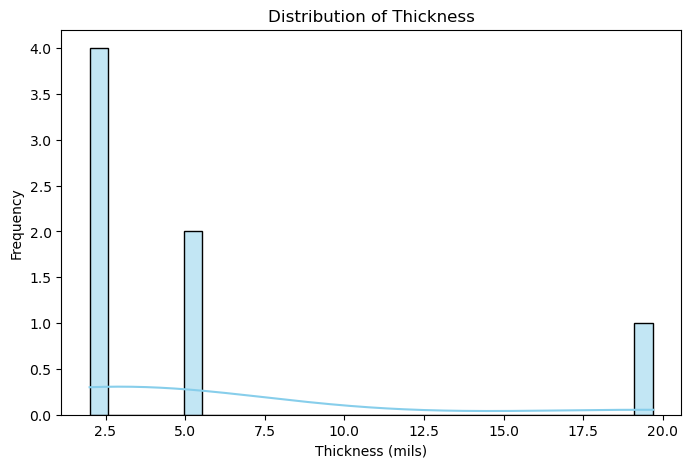

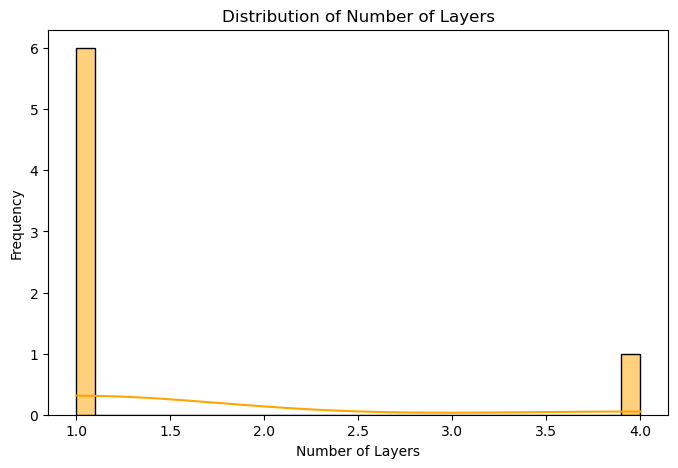

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histogram of Thickness (mils)
plt.figure(figsize=(8,5))
sns.histplot(df["Thickness (mils)"], kde=True, color='skyblue', bins=30)
plt.title("Distribution of Thickness")
plt.xlabel("Thickness (mils)")
plt.ylabel("Frequency")
plt.show()

# Histogram of Number of Layers
plt.figure(figsize=(8,5))
sns.histplot(df["Number of Layers"], kde=True, color='orange', bins=30)
plt.title("Distribution of Number of Layers")
plt.xlabel("Number of Layers")
plt.ylabel("Frequency")
plt.show()


---- PDF1_Erosion_Yields ----
   Solar Exposure (ESH)  AO Fluence (atoms/cm2)  Ey (cm3/atom)
0                  1400            2.150000e+21   1.280000e-25
1                  2400            4.220000e+21   1.810000e-25
2                  2600            1.970000e+21   1.690000e-25
3                  3200            4.620000e+21   2.390000e-25
4                  6100            8.510000e+21   2.110000e-25 



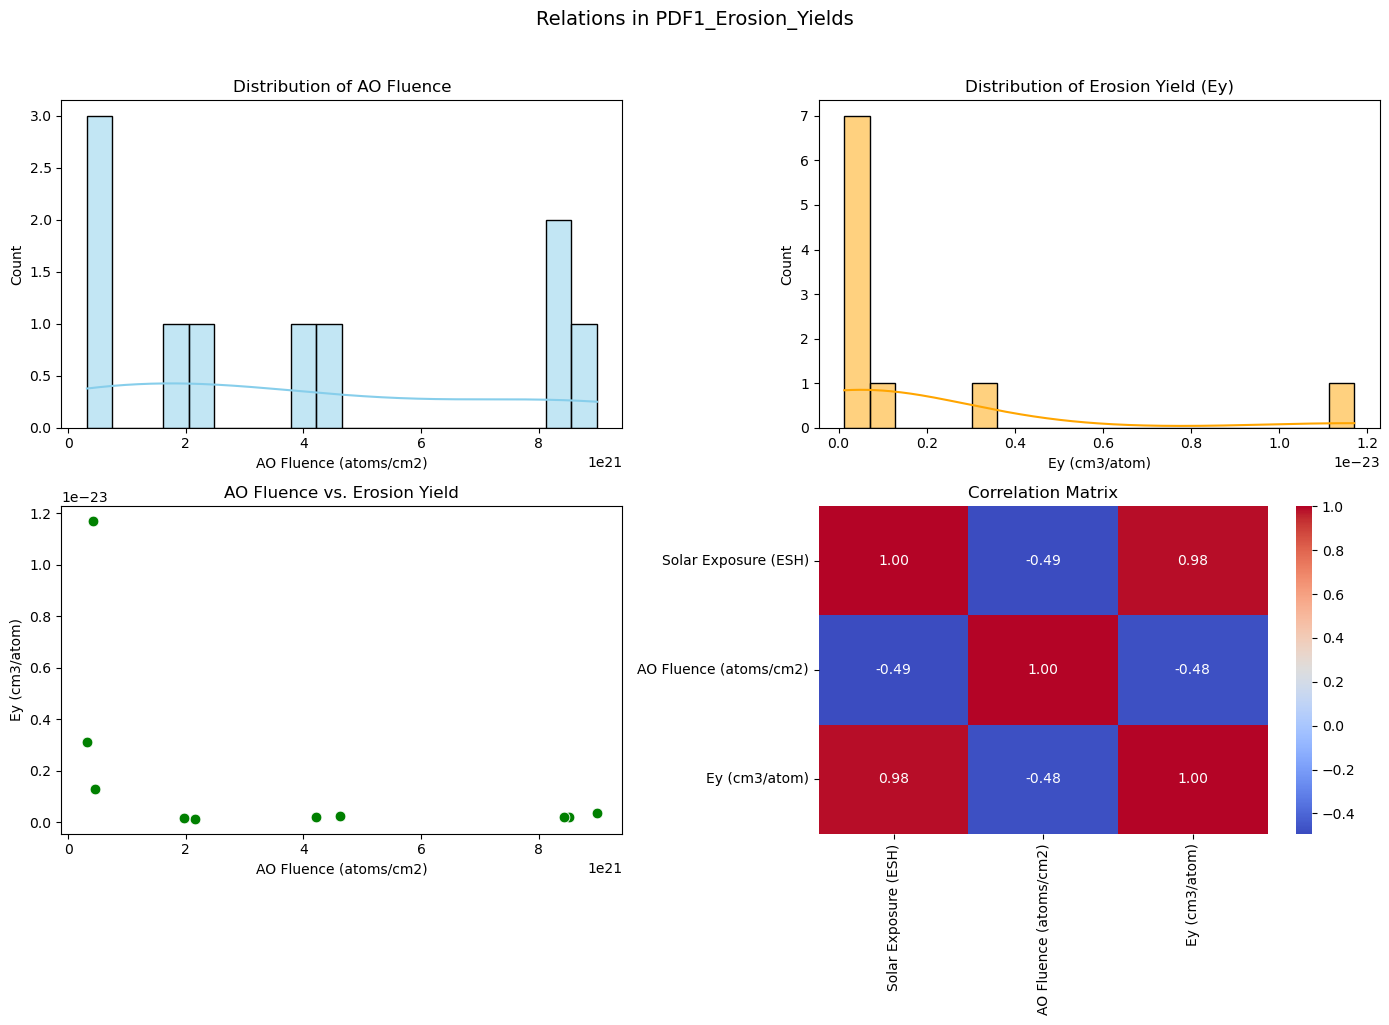

---- PDF2_MISSE2_ErosionYield ----
Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4] 



<Figure size 1400x1000 with 0 Axes>

---- PDF6_MISSE_6_ErosionYield_Resul ----
   Non-Stressed Ey (cm³/atom)  Stressed Ey (cm³/atom)  \
0                1.330000e-25            1.010000e-25   
1                1.690000e-25            1.410000e-25   
2                1.650000e-24            1.710000e-24   
3                2.160000e-24            2.410000e-24   
4                2.700000e-24            2.550000e-24   

   Ratio Stressed/Nonstressed Ey  
0                           0.76  
1                           0.83  
2                           1.04  
3                           1.11  
4                           0.95   



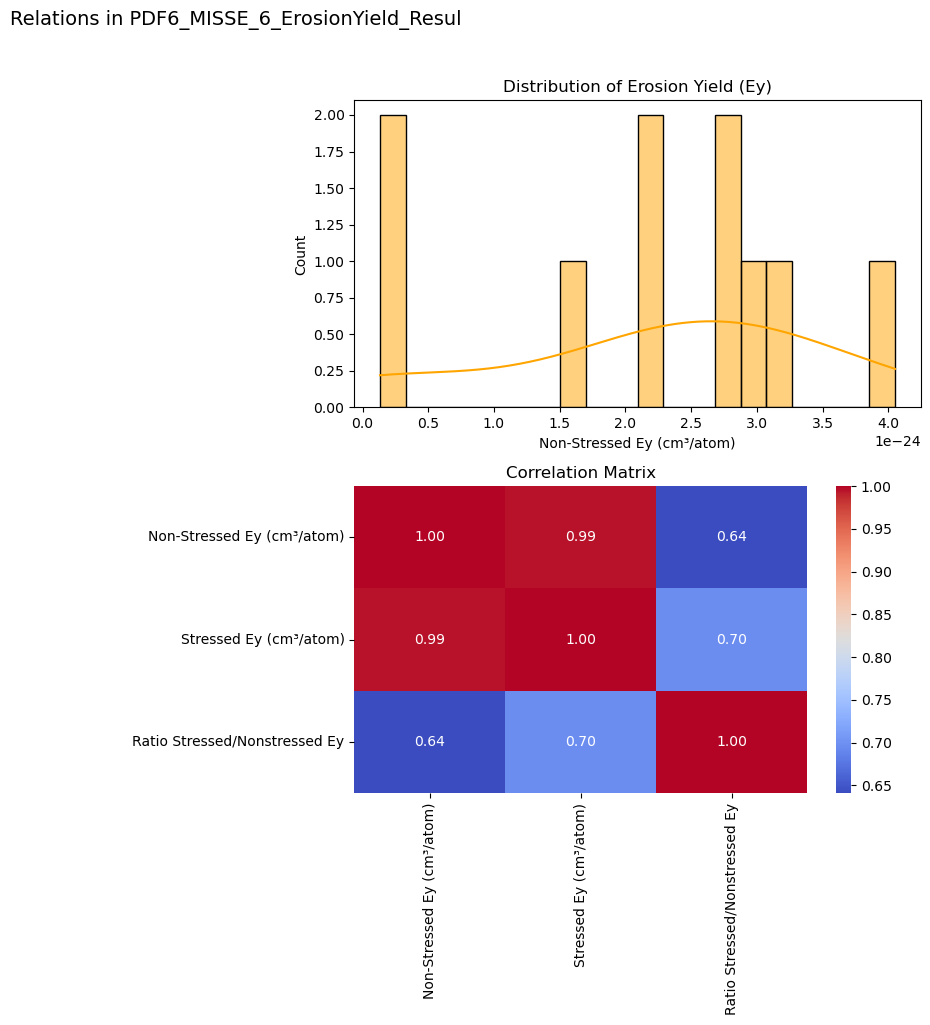

---- PDF8_MISSE8_Ram_Ey ----
   AO Fluence (atoms/cm²)  Ey (cm³/atom)
1            4.620000e+21   2.390000e-25
2            4.620000e+21   1.450000e-25
3            4.620000e+21   2.500000e-25
4            4.620000e+21   1.940000e-25
5            4.620000e+21   2.370000e-25 



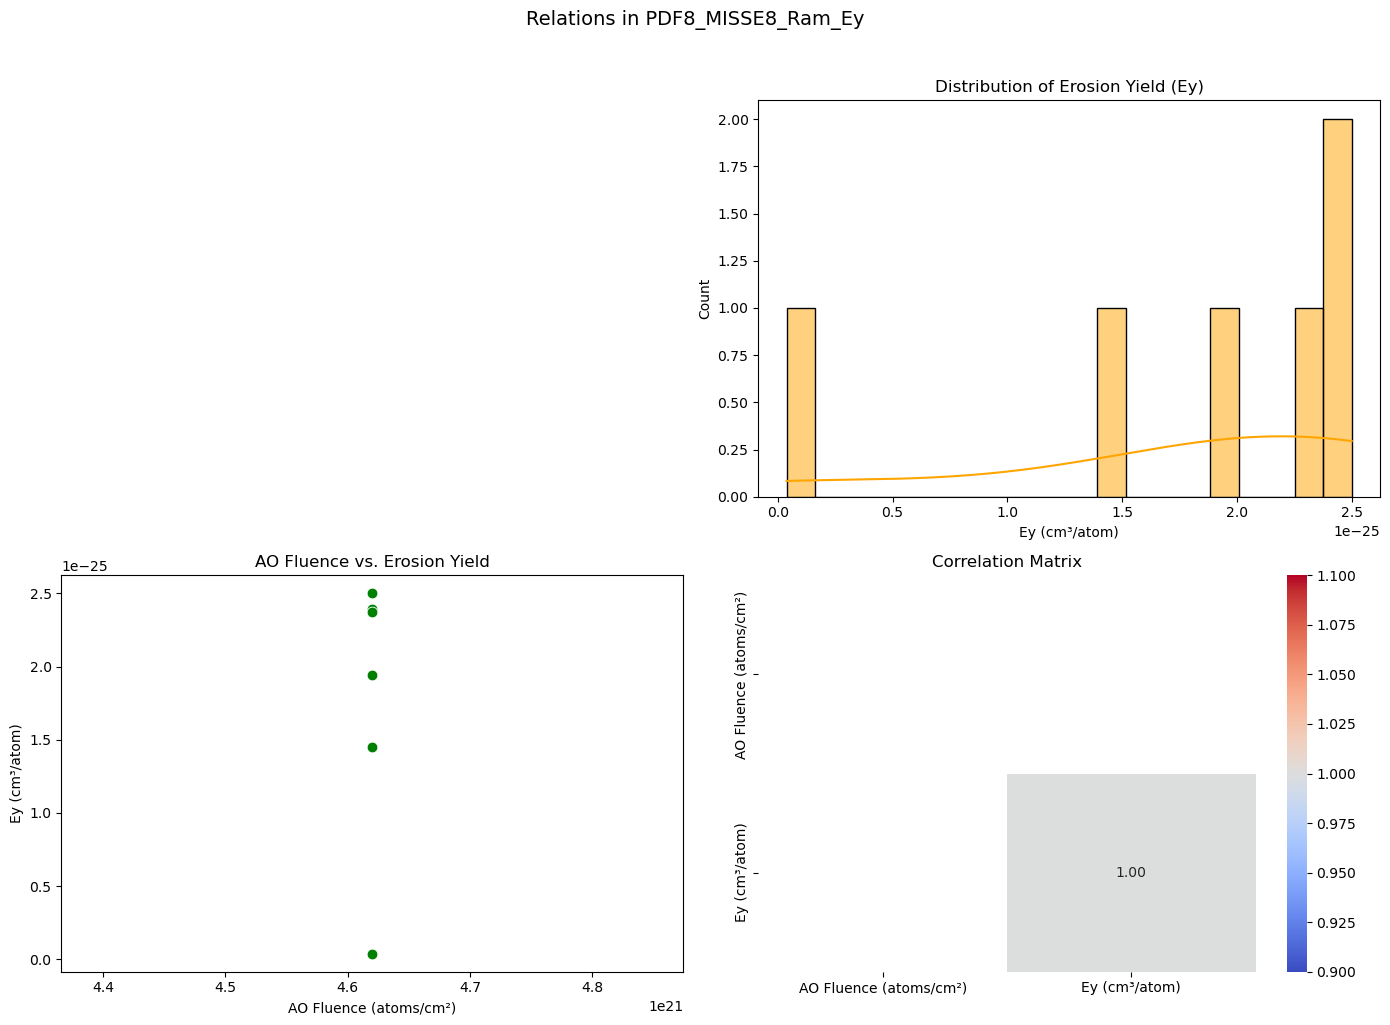

---- PDF8_MISSE8_Wake_Ey ----
   AO Fluence (atoms/cm²)  Ey (cm³/atom)
1            8.800000e+19   1.100000e-24
2            8.800000e+19   1.040000e-24
3            8.800000e+19   1.080000e-24 



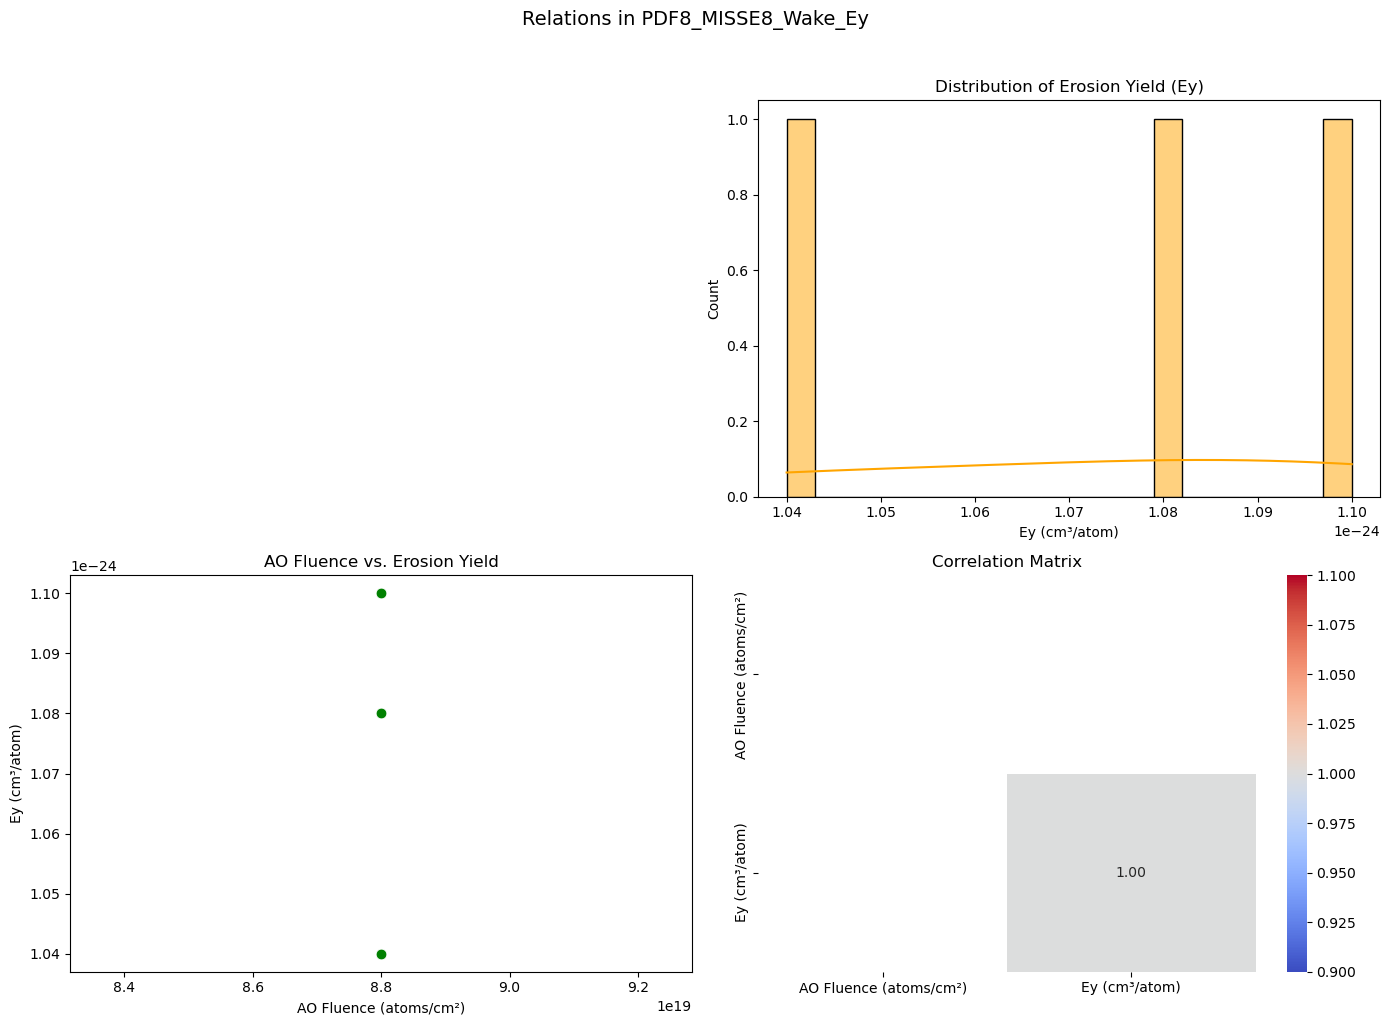

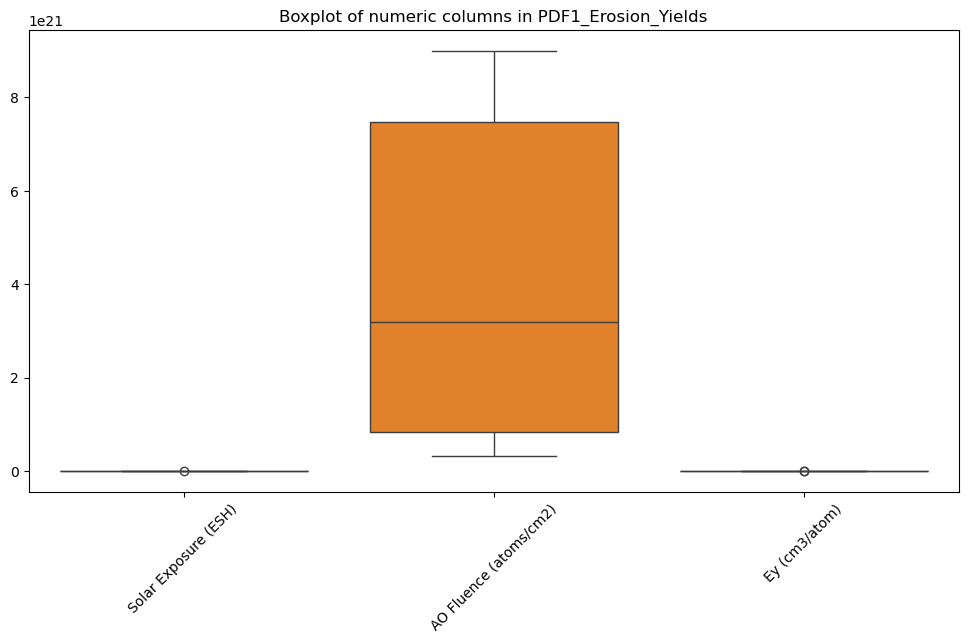

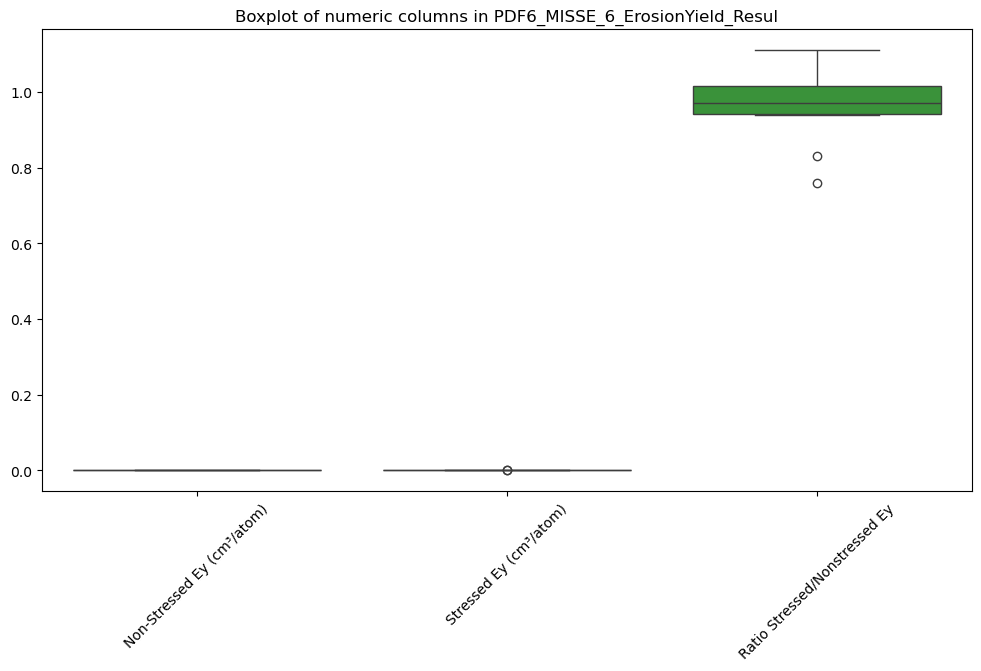

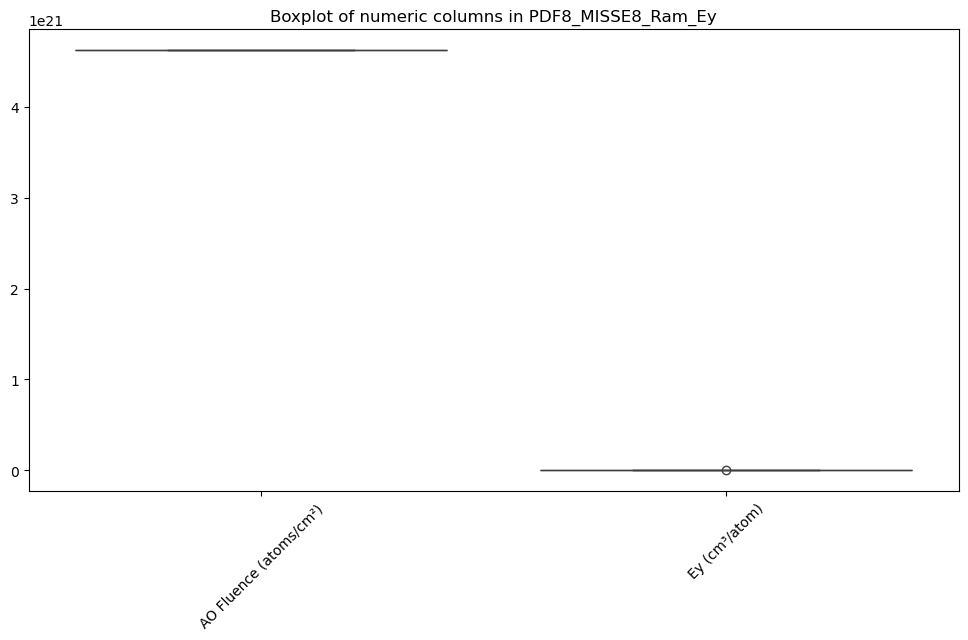

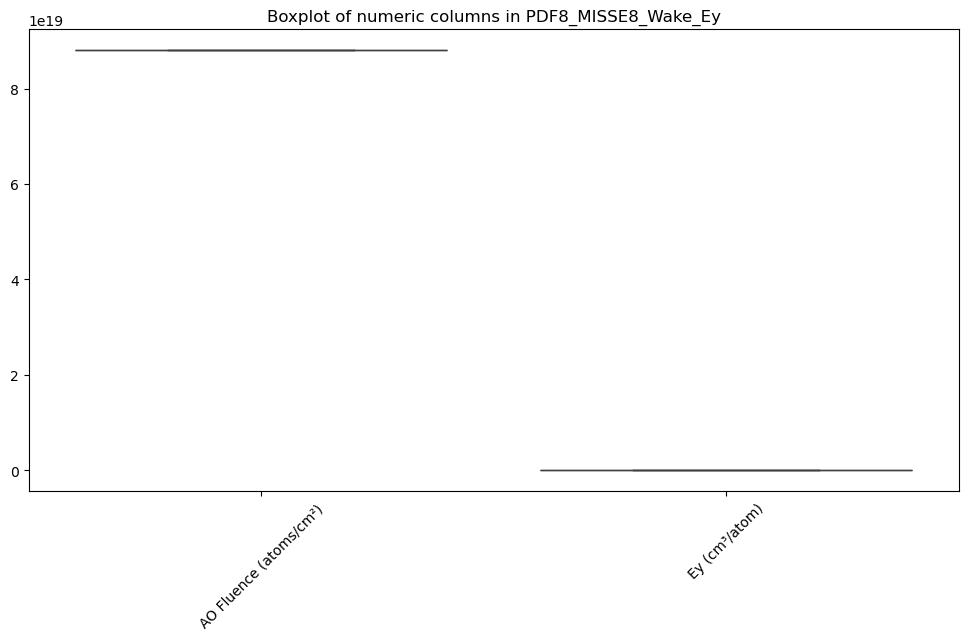

In [29]:
for sheet in sheets:
    df = pd.read_excel(file_path, sheet_name=sheet)
    cols = [c for c in df.columns if "Fluence" in c or "Ey" in c or "Exposure" in c]
    data = df[cols].apply(pd.to_numeric, errors="coerce").replace([np.inf, -np.inf], np.nan).dropna()
    
    if data.empty:
        continue

    plt.figure(figsize=(12,6))
    sns.boxplot(data=data)
    plt.title(f"Boxplot of numeric columns in {sheet}")
    plt.xticks(rotation=45)
    plt.show()


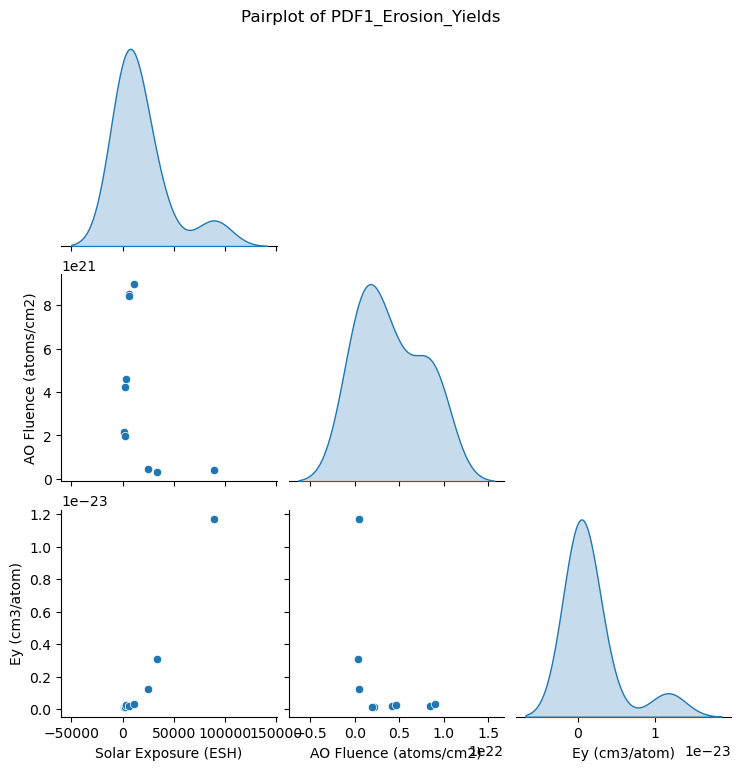

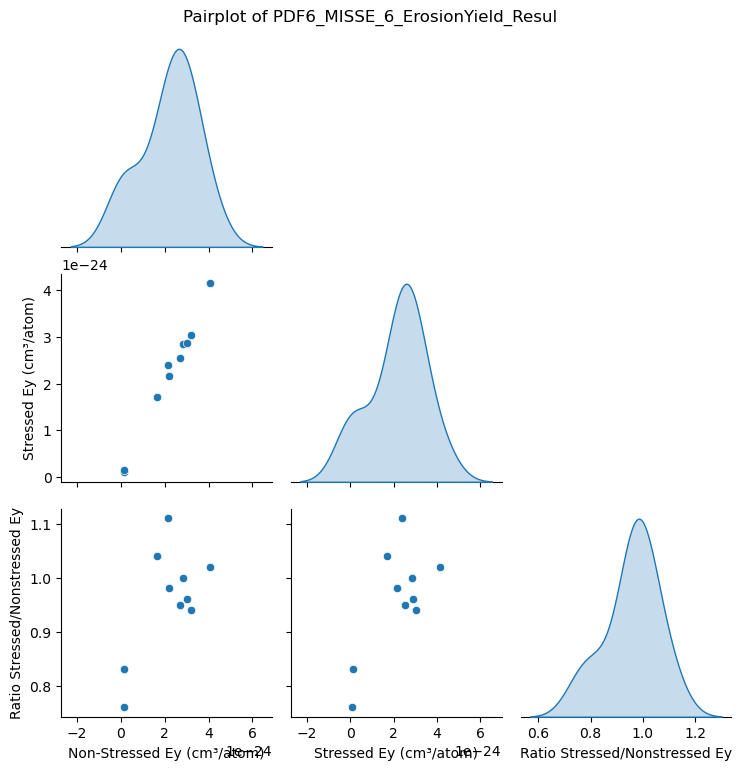

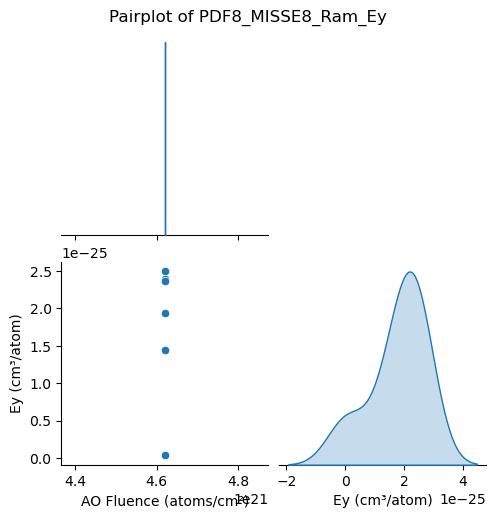

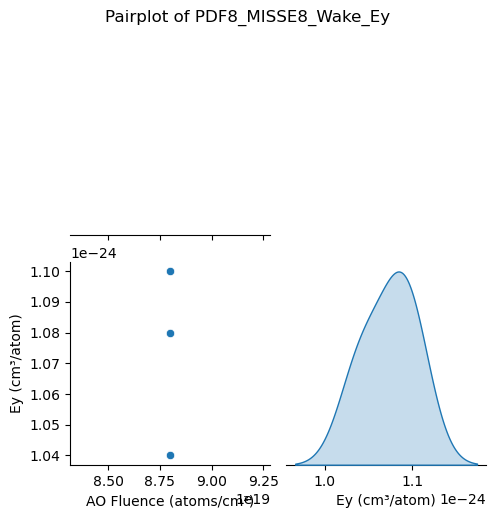

In [31]:
for sheet in sheets:
    df = pd.read_excel(file_path, sheet_name=sheet)
    cols = [c for c in df.columns if "Fluence" in c or "Ey" in c or "Exposure" in c]
    data = df[cols].apply(pd.to_numeric, errors="coerce").replace([np.inf, -np.inf], np.nan).dropna()
    
    if data.shape[1] > 1 and data.shape[0] > 1:
        sns.pairplot(data, kind='scatter', diag_kind='kde', corner=True)
        plt.suptitle(f"Pairplot of {sheet}", y=1.02)
        plt.show()


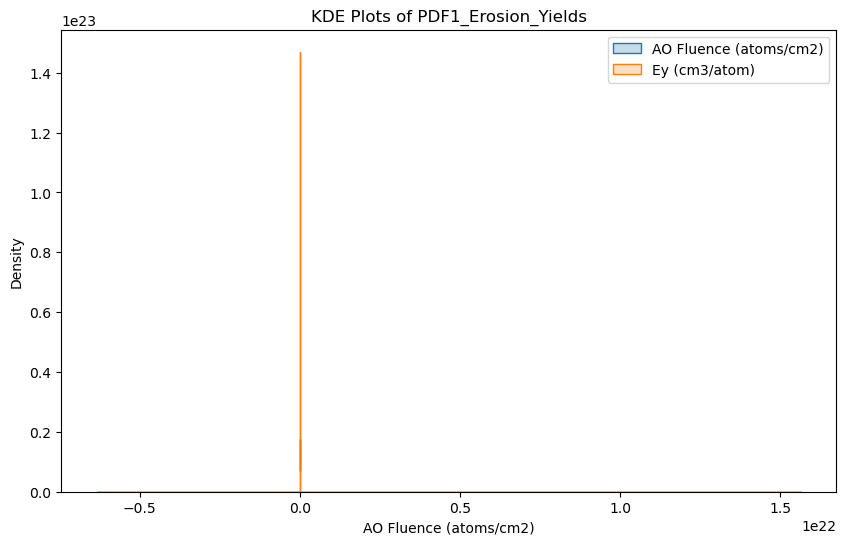

No valid numeric data with variance to plot for sheet PDF2_MISSE2_ErosionYield


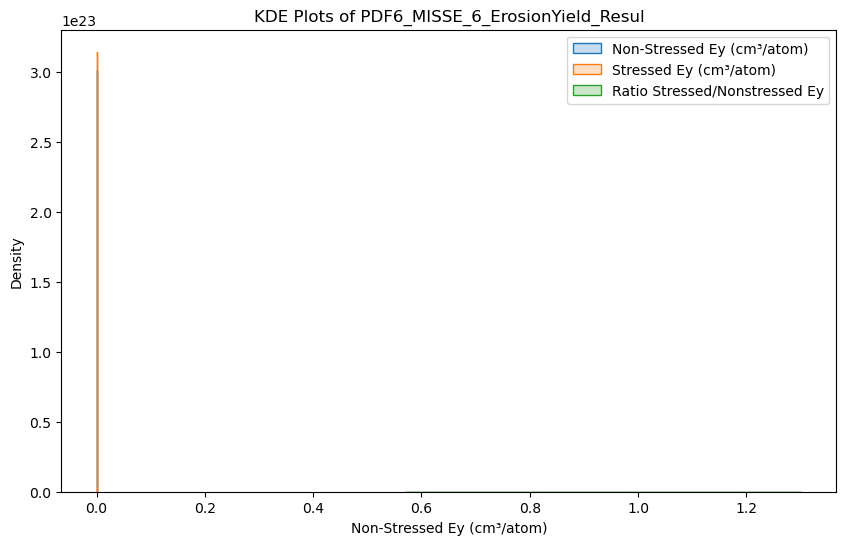

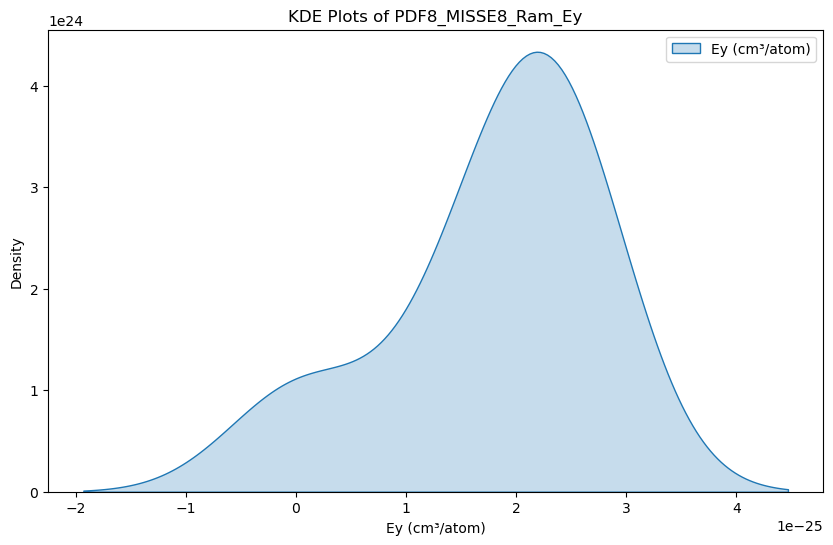

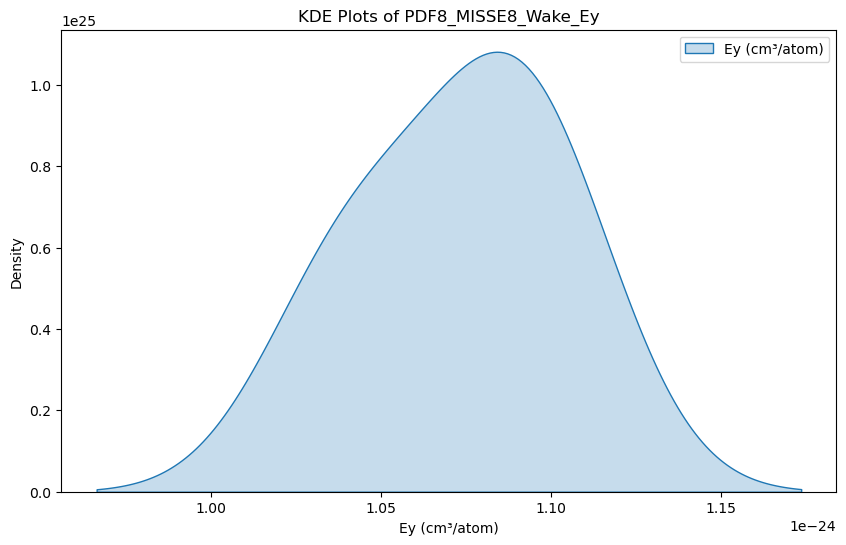

In [43]:
for sheet in sheets:
    df = pd.read_excel(file_path, sheet_name=sheet)
    cols = [c for c in df.columns if "Ey" in c or "Fluence" in c]

    # Convert to numeric (coerce errors to NaN)
    data = df[cols].apply(pd.to_numeric, errors="coerce")

    # Keep only columns with at least 2 unique values
    data = data.loc[:, data.nunique() > 1]

    if not data.empty:
        plt.figure(figsize=(10,6))
        for col in data.columns:
            sns.kdeplot(data[col].dropna(), fill=True, label=col)
        plt.title(f"KDE Plots of {sheet}")
        plt.legend()
        plt.show()
    else:
        print(f"No valid numeric data with variance to plot for sheet {sheet}")


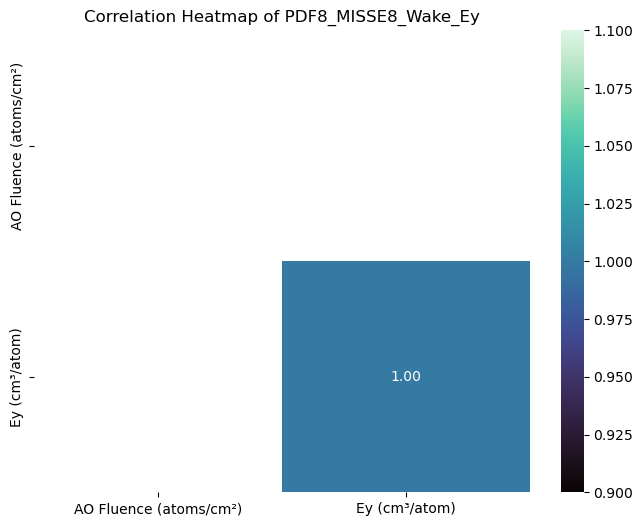

In [39]:
for sheet in sheets:
   data = df[cols].apply(pd.to_numeric, errors="coerce").dropna()

if not data.empty and data.shape[1] > 1:  # Need at least 2 columns for correlation
    plt.figure(figsize=(8,6))
    sns.heatmap(data.corr(), annot=True, fmt=".2f", cmap="mako")
    plt.title(f"Correlation Heatmap of {sheet}")
    plt.show()
else:
    print(f"No valid numeric data to plot for sheet {sheet}")



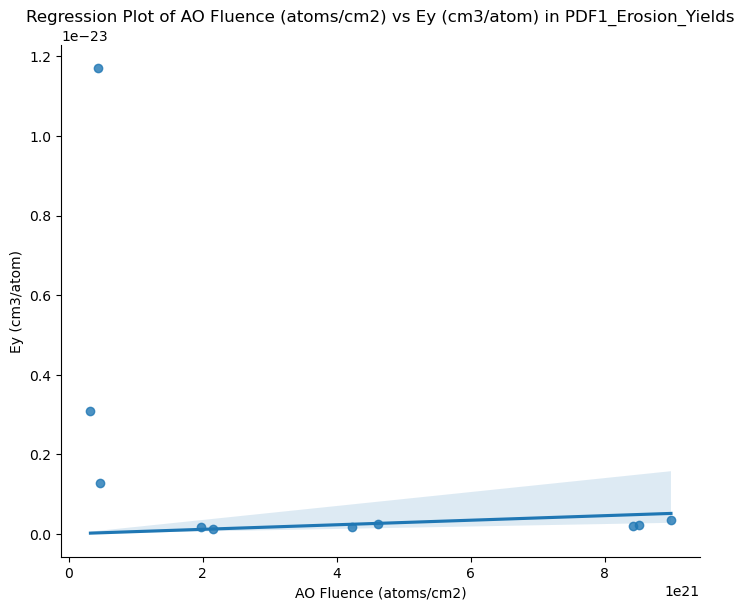

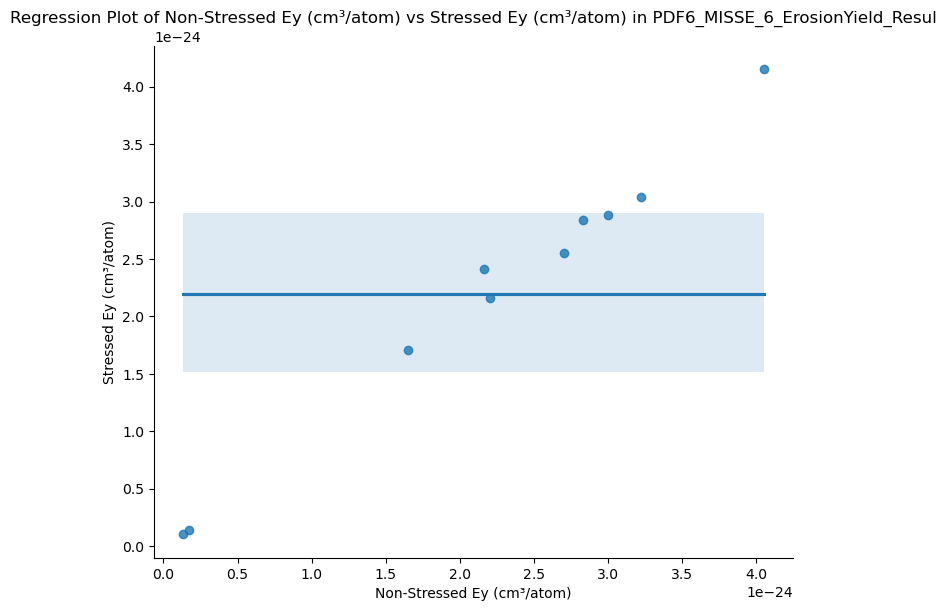

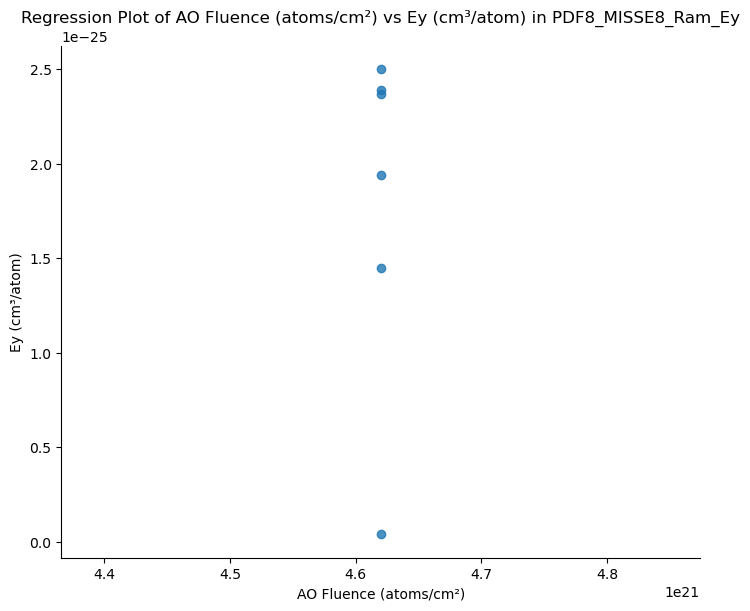

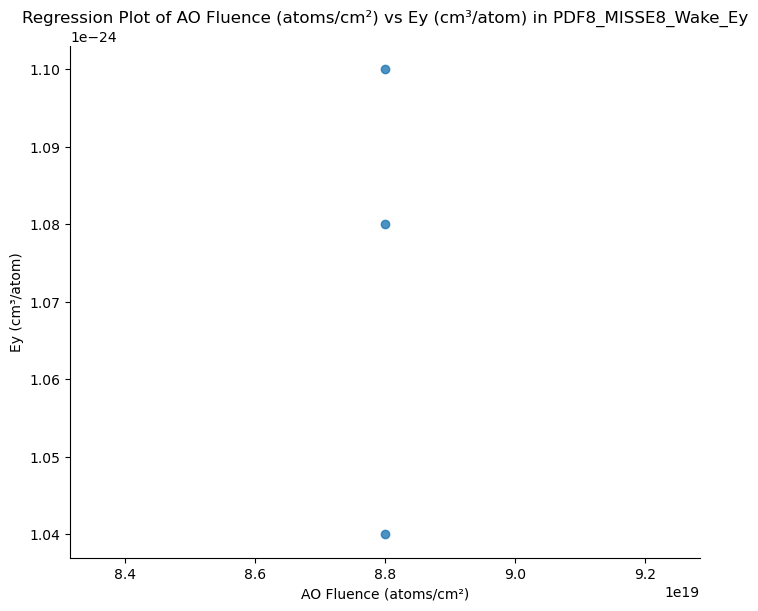

In [37]:
for sheet in sheets:
    df = pd.read_excel(file_path, sheet_name=sheet)
    cols = [c for c in df.columns if "Ey" in c or "Fluence" in c]
    data = df[cols].apply(pd.to_numeric, errors="coerce").dropna()
    
    if len(cols) >= 2:
        sns.lmplot(x=cols[0], y=cols[1], data=data, height=6, aspect=1.2)
        plt.title(f"Regression Plot of {cols[0]} vs {cols[1]} in {sheet}")
        plt.show()


In [51]:
import pandas as pd

# Load Excel
file_path = "MergedExcel.xlsx"  # (adjust path if needed)
xls = pd.ExcelFile(file_path)

# Load required sheets
polymers_df = pd.read_excel(file_path, sheet_name="PDF6_MISSE_6_Polymers")
erosion_df = pd.read_excel(file_path, sheet_name="PDF6_MISSE_6_ErosionYield_Resul")
mission_erosion_df = pd.read_excel(file_path, sheet_name="PDF1_Erosion_Yields")

# Clean column names
polymers_df.columns = polymers_df.columns.str.strip().str.replace(" ", "_")
erosion_df.columns = erosion_df.columns.str.strip().str.replace(" ", "_")
mission_erosion_df.columns = mission_erosion_df.columns.str.strip().str.replace(" ", "_")

# Merge (erosion + polymers + mission info)
merged_df = erosion_df.merge(polymers_df, left_on="Material", right_on="Material_Name", how="left")
merged_df = merged_df.merge(mission_erosion_df, left_on="Material", right_on="Material_(5_mil)", how="left")

print("✅ Merged dataset ready with shape:", merged_df.shape)
merged_df.head()


✅ Merged dataset ready with shape: (10, 24)


,MISSE_6_GRC_ID,Material,Non-Stressed_Mass_Loss_(g),Non-Stressed_Ey_(cm³/atom),Stressed_Mass_Loss_(g),Stressed_Ey_(cm³/atom),Strain_at_External_Surface,Ratio_Stressed/Nonstressed_Ey,Sample_ID,Material_Name,...,Total_Thickness_(mils),Notes,Mission,Material_(5_mil),Flight_Orientation,Mission_Duration_(yrs),Solar_Exposure_(ESH),AO_Fluence_(atoms/cm2),Ey_(cm3/atom),Reference
0,N1 & S1,Teflon PTFE,0.002444,1.330000e-25,0.000824,1.010000e-25,0.01040,0.76,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,N2 & S2,Teflon FEP,0.003098,1.690000e-25,0.001144,1.410000e-25,0.01040,0.83,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,N3 & S3,Upilex-S,0.019478,1.650000e-24,0.009011,1.710000e-24,0.00208,1.04,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,N4 & S4,CP1,0.026214,2.160000e-24,0.012964,2.410000e-24,0.00208,1.11,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,N5 & S5,Kapton CB,0.032691,2.700000e-24,0.013720,2.550000e-24,0.01040,0.95,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


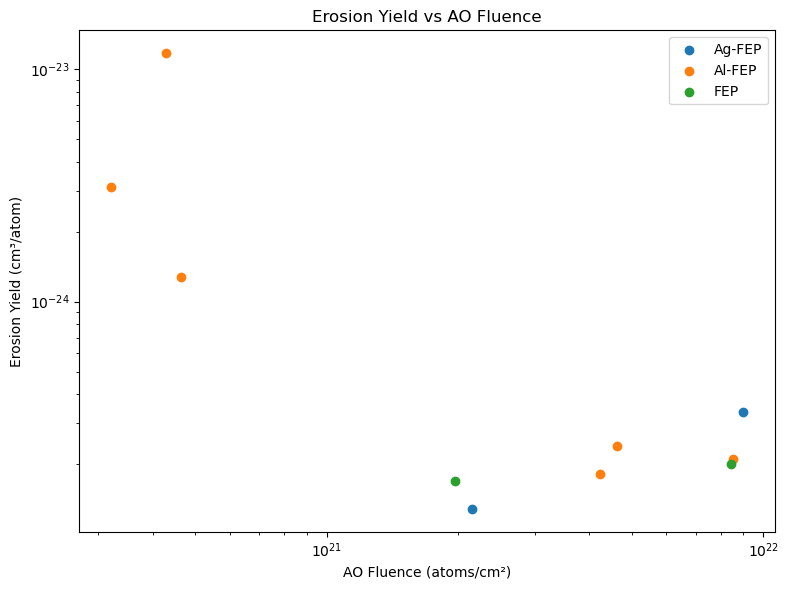

In [53]:
# Using mission dataset
mission_plot = mission_erosion_df.dropna(subset=["AO_Fluence_(atoms/cm2)", "Ey_(cm3/atom)"])

plt.figure(figsize=(8,6))
for material in mission_plot["Material_(5_mil)"].unique():
    subset = mission_plot[mission_plot["Material_(5_mil)"] == material]
    plt.scatter(subset["AO_Fluence_(atoms/cm2)"], subset["Ey_(cm3/atom)"], label=material)

plt.xscale("log")  # AO fluence spans orders of magnitude
plt.yscale("log")
plt.xlabel("AO Fluence (atoms/cm²)")
plt.ylabel("Erosion Yield (cm³/atom)")
plt.title("Erosion Yield vs AO Fluence")
plt.legend()
plt.tight_layout()
plt.show()


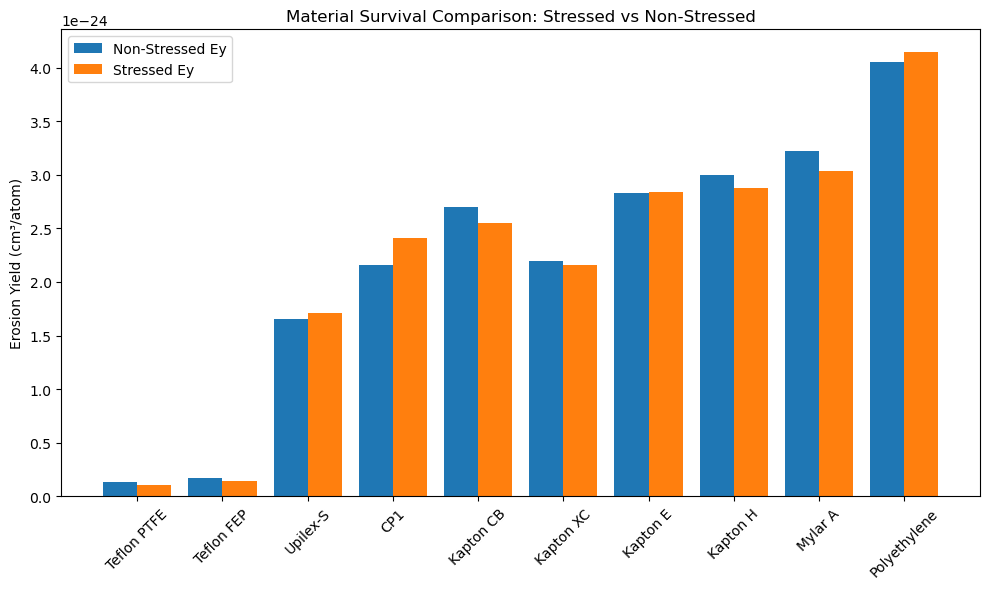

In [55]:
import matplotlib.pyplot as plt

# Filter relevant columns
plot_df = merged_df[[
    "Material",
    "Non-Stressed_Ey_(cm³/atom)",
    "Stressed_Ey_(cm³/atom)"
]].dropna()

# Plot comparison
plt.figure(figsize=(10,6))
x = range(len(plot_df))
plt.bar(x, plot_df["Non-Stressed_Ey_(cm³/atom)"], width=0.4, label="Non-Stressed Ey")
plt.bar([i+0.4 for i in x], plot_df["Stressed_Ey_(cm³/atom)"], width=0.4, label="Stressed Ey")
plt.xticks([i+0.2 for i in x], plot_df["Material"], rotation=45)
plt.ylabel("Erosion Yield (cm³/atom)")
plt.title("Material Survival Comparison: Stressed vs Non-Stressed")
plt.legend()
plt.tight_layout()
plt.show()


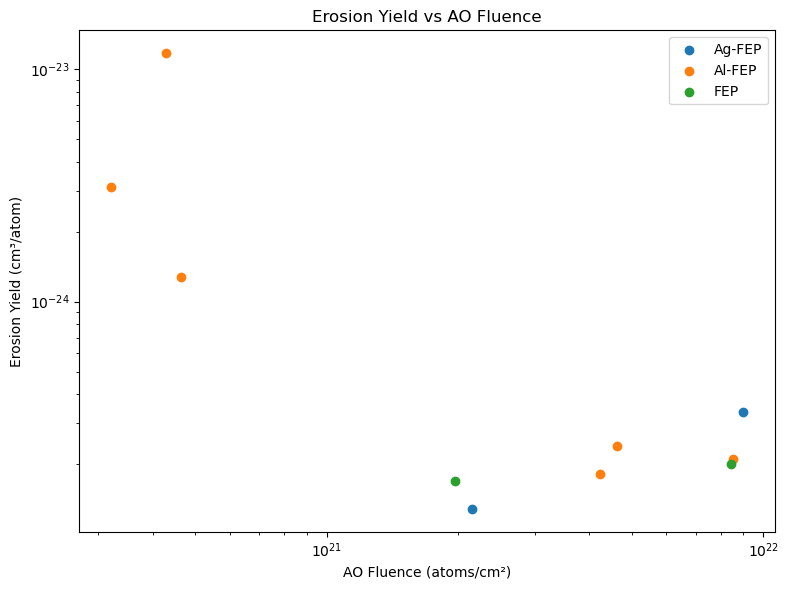

In [57]:
# Using mission dataset
mission_plot = mission_erosion_df.dropna(subset=["AO_Fluence_(atoms/cm2)", "Ey_(cm3/atom)"])

plt.figure(figsize=(8,6))
for material in mission_plot["Material_(5_mil)"].unique():
    subset = mission_plot[mission_plot["Material_(5_mil)"] == material]
    plt.scatter(subset["AO_Fluence_(atoms/cm2)"], subset["Ey_(cm3/atom)"], label=material)

plt.xscale("log")  # AO fluence spans orders of magnitude
plt.yscale("log")
plt.xlabel("AO Fluence (atoms/cm²)")
plt.ylabel("Erosion Yield (cm³/atom)")
plt.title("Erosion Yield vs AO Fluence")
plt.legend()
plt.tight_layout()
plt.show()


In [63]:
import numpy as np

# Rebuild merged_df with better mission mapping
merged_df = erosion_df.merge(polymers_df, left_on="Material", right_on="Material_Name", how="left")

# Add exposure data from mission erosion dataset
exposure_data = mission_erosion_df[["Material_(5_mil)", "Solar_Exposure_(ESH)", "AO_Fluence_(atoms/cm2)"]]
merged_df = merged_df.merge(exposure_data, left_on="Material", right_on="Material_(5_mil)", how="left")

# Fill missing values more safely (only numeric columns)
for col in ["Non-Stressed_Ey_(cm³/atom)", "Non-Stressed_Mass_Loss_(g)", "Total_Thickness_(mils)", 
            "Solar_Exposure_(ESH)", "AO_Fluence_(atoms/cm2)"]:
    merged_df[col] = merged_df[col].fillna(0)

# Compute MSS again
alpha, beta, gamma = 1, 1, 1
merged_df["MSS"] = 1 / (
    1 
    + alpha * merged_df["Non-Stressed_Ey_(cm³/atom)"] 
    + beta * (merged_df["Non-Stressed_Mass_Loss_(g)"] / (merged_df["Total_Thickness_(mils)"] + 1e-9))
    + gamma * (merged_df["Solar_Exposure_(ESH)"] / (merged_df["AO_Fluence_(atoms/cm2)"] + 1e-9))
)
merged_df["MSS"] = merged_df["MSS"].clip(0,1)

# Preview again
merged_df[["Material", "Non-Stressed_Ey_(cm³/atom)", "Solar_Exposure_(ESH)", "AO_Fluence_(atoms/cm2)", "MSS"]].head()



,Material,Non-Stressed_Ey_(cm³/atom),Solar_Exposure_(ESH),AO_Fluence_(atoms/cm2),MSS
0,Teflon PTFE,1.330000e-25,0.0,0.0,4.091651e-07
1,Teflon FEP,1.690000e-25,0.0,0.0,3.227888e-07
2,Upilex-S,1.650000e-24,0.0,0.0,5.133997e-08
3,CP1,2.160000e-24,0.0,0.0,3.814755e-08
4,Kapton CB,2.700000e-24,0.0,0.0,3.058946e-08


In [69]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Pick features to normalize
features = ["Non-Stressed_Ey_(cm³/atom)", 
            "Non-Stressed_Mass_Loss_(g)", 
            "Total_Thickness_(mils)", 
            "Solar_Exposure_(ESH)", 
            "AO_Fluence_(atoms/cm2)"]

# Replace NaNs with 0
merged_df[features] = merged_df[features].fillna(0)

# Scale to [0,1]
merged_df_scaled = pd.DataFrame(
    scaler.fit_transform(merged_df[features]),
    columns=[f + "_scaled" for f in features]
)

# Attach back to main df
merged_df = pd.concat([merged_df, merged_df_scaled], axis=1)


In [77]:
from sklearn.preprocessing import MinMaxScaler

# Select numeric features
features = [
    "Non-Stressed_Ey_(cm³/atom)", 
    "Non-Stressed_Mass_Loss_(g)", 
    "Total_Thickness_(mils)", 
    "Solar_Exposure_(ESH)", 
    "AO_Fluence_(atoms/cm2)"
]

# Fill NaNs with 0
merged_df[features] = merged_df[features].fillna(0)

# Scale features
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(merged_df[features])

# Put back with correct index
scaled_df = pd.DataFrame(scaled_values, 
                         columns=[f + "_scaled" for f in features], 
                         index=merged_df.index)

# Attach to merged_df
for col in scaled_df.columns:
    merged_df[col] = scaled_df[col]   # ensures Series, not DataFrame

# Double-check column list
print("Available columns:", merged_df.columns[-10:])

# 🔥 Remove duplicate columns
merged_df = merged_df.loc[:, ~merged_df.columns.duplicated()].copy()


alpha, beta, gamma = 1, 1, 1

merged_df["MSS"] = 1 / (
    1
    + alpha * merged_df["Non-Stressed_Ey_(cm³/atom)_scaled"].astype(float)
    + beta * (
        merged_df["Non-Stressed_Mass_Loss_(g)_scaled"].astype(float) /
        (merged_df["Total_Thickness_(mils)_scaled"].astype(float) + 1e-9)
    )
    + gamma * (
        merged_df["Solar_Exposure_(ESH)_scaled"].astype(float) /
        (merged_df["AO_Fluence_(atoms/cm2)_scaled"].astype(float) + 1e-9)
    )
)

merged_df["MSS"] = merged_df["MSS"].clip(0,1)

print(merged_df[["Material", "MSS"]].head())



Available columns: Index(['Non-Stressed_Ey_(cm³/atom)_scaled',
       'Non-Stressed_Mass_Loss_(g)_scaled', 'Total_Thickness_(mils)_scaled',
       'Solar_Exposure_(ESH)_scaled', 'AO_Fluence_(atoms/cm2)_scaled',
       'Non-Stressed_Ey_(cm³/atom)_scaled',
       'Non-Stressed_Mass_Loss_(g)_scaled', 'Total_Thickness_(mils)_scaled',
       'Solar_Exposure_(ESH)_scaled', 'AO_Fluence_(atoms/cm2)_scaled'],
      dtype='object')
      Material           MSS
0  Teflon PTFE  1.000000e+00
1   Teflon FEP  5.478899e-08
2     Upilex-S  2.103558e-09
3          CP1  1.507446e-09
4    Kapton CB  1.184646e-09


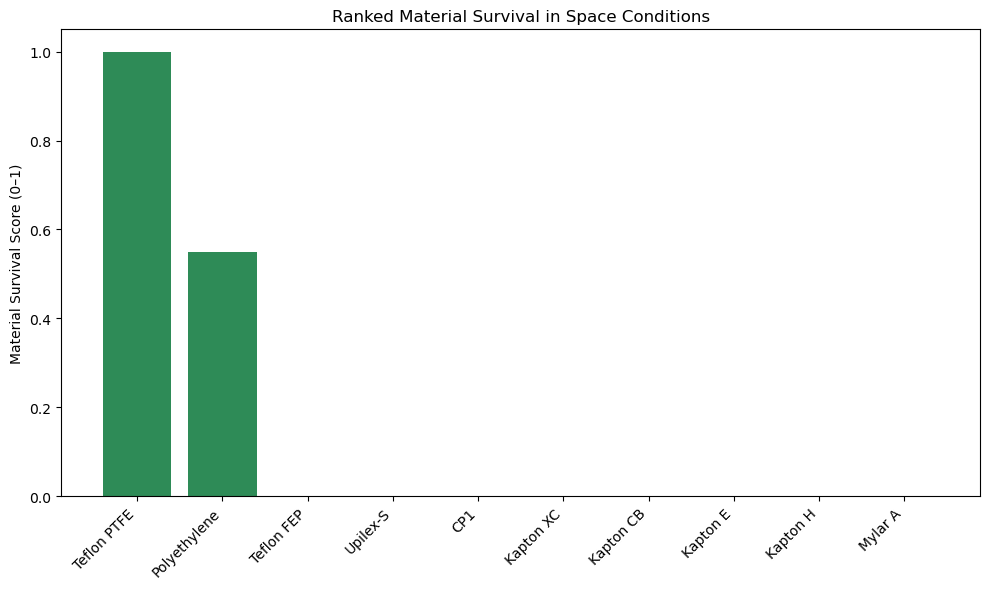

In [79]:
import matplotlib.pyplot as plt

# Sort materials by MSS
ranked_df = merged_df.sort_values("MSS", ascending=False)

plt.figure(figsize=(10,6))
plt.bar(ranked_df["Material"], ranked_df["MSS"], color="seagreen")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Material Survival Score (0–1)")
plt.title("Ranked Material Survival in Space Conditions")
plt.tight_layout()
plt.show()
